In [23]:
import numpy
import keras
import os
import tensorflow as tf
import numpy as np
import time
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  
from numpy import asarray
from numpy import savez_compressed
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image 
import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 
from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 
import tensorflow as tf 

In [24]:
np.load.__defaults__=(None, True, True, 'ASCII')
# data= np.load('all_image_data.npy')

In [25]:
# Time 
def _time(start, end): 
    # if in seconds 
    if (end-start)<60: 
        wall_time = f'{round((end-start),2)}sec'
    # if in minute(s)  
    elif (end-start)>=3600: 
        wall_time = f'{int((end-start)/3600)}h {int(((end-start)%3600)/60)}min {round((end-start)%60,2)}sec'
    # if in houre(s)  
    else: 
        wall_time = f'{int((end-start)/60)}min {round((end-start)%60,2)}sec'
    return wall_time 

In [26]:
start=time.time()

data = np.load('all_image_data.npy')[0]

end=time.time()


# print("\nData summary:\n", data)
print("\nData shape:\n", data.shape)
print(f"\nTime to read: {round(end-start,5)} seconds.")



Data shape:
 (1164, 2, 1)

Time to read: 1.29658 seconds.


In [27]:
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
np_img = data[5][0][0]
# print(np_img.shape)
# print(np_img)
# plt.imshow(np_img)
# plt.show()

In [28]:
IMG_HEIGHT,IMG_WIDTH = (256, 256)

In [29]:
def get_data(filename, dim=(IMG_HEIGHT,IMG_WIDTH), rand_shuffle=True):
   
    img_data_array = []
   
    for ii, file in enumerate(data):
       
        image = data[ii][0][0]
        image = image.astype('float32')
        image /= 256
        img_data_array.append(image)
            
    img_data_array = np.array(img_data_array)
    
            
    return img_data_array

In [30]:
# extract the image array and class name
img_data = get_data(data)

In [74]:
batch_size = 64
n_epoch = 1000
latent_dim = 100 
cols, rows = 256, 256 
channels = 3 
dim = cols, rows # height, width 
in_shape = (cols, rows, channels) # height, width, color 
lr = 0.0002
beta1 = 0.5
nrows, ncols = 3, 4

In [75]:
def define_discriminator(in_shape=(256,256, 3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(64, (5,5), padding='same', input_shape=in_shape)) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 32x32 
    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(1024, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # compile model 
    opt = optimizers.Adam(lr=0.00002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model


In [76]:
model = define_discriminator()
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 256, 256, 64)      4864      
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 128, 128, 128)     204928    
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 256)       819456    
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 512)     

In [77]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 1024*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 1024)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(512, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(64, (4,4), strides=(4,4), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model 

In [78]:
model = define_generator(latent_dim)
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 65536)             6619136   
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 65536)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 16, 16, 512)       8389120   
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 32, 32, 256)       2097408   
_________________________________________________________________
leaky_re_lu_88 (LeakyReLU)   (None, 32, 32, 256)     

In [79]:
#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

In [80]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [81]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = optimizers.Adam(lr=0.0001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [82]:
# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [83]:
# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off')
    #folder_path = os.path.abspath(os.getcwd())
    #gen_images_file_path = os.path.join(folder_path, '/GeneratedImages/image_at_epoch_{:04d}.png'.format(epoch+1))
    #plt.savefig(gen_images_file_path)
    plt.savefig('/home/aiuser1/other/GeneratedImages/image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

In [84]:
# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch)
    # save the generator model tile file
    #folder_path = os.path.abspath(os.getcwd())
    #filename = os.path.join(folder_path, f'/model/generator_model_{epoch+1}03d.h5')
    filename = '/home/aiuser1/other/model/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [85]:
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

In [86]:
def plot_acc(acc):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator accuracy During Training", fontsize=20) 
    plt.plot(acc[0], label="acc_real") 
    plt.plot(acc[1], label="acc_fake") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("accuracy", fontsize=20) 
    plt.legend(); plt.show()


Training Start...


/home/aiuser1/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/aiuser1/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/aiuser1/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 001/1000, Loss: [D_real = 0.670, D_fake = 0.657, G = 0.857], time: 21.11sec
Epoch: 002/1000, Loss: [D_real = 0.622, D_fake = 0.782, G = 0.723], time: 18.85sec
Epoch: 003/1000, Loss: [D_real = 0.563, D_fake = 0.749, G = 0.846], time: 18.93sec
Epoch: 004/1000, Loss: [D_real = 0.445, D_fake = 0.970, G = 0.720], time: 18.95sec
Epoch: 005/1000, Loss: [D_real = 0.489, D_fake = 0.949, G = 0.608], time: 19.01sec
Epoch: 006/1000, Loss: [D_real = 0.620, D_fake = 0.749, G = 0.719], time: 19.0sec
Epoch: 007/1000, Loss: [D_real = 0.714, D_fake = 0.735, G = 0.758], time: 19.03sec
Epoch: 008/1000, Loss: [D_real = 0.606, D_fake = 0.667, G = 0.773], time: 19.01sec
Epoch: 009/1000, Loss: [D_real = 0.712, D_fake = 0.663, G = 0.754], time: 19.06sec
Epoch: 010/1000, Loss: [D_real = 0.659, D_fake = 0.710, G = 0.727], time: 19.06sec
Epoch: 011/1000, Loss: [D_real = 0.649, D_fake = 0.700, G = 0.728], time: 19.01sec
Epoch: 012/1000, Loss: [D_real = 0.582, D_fake = 0.704, G = 0.750], time: 19.03sec
Epoch

Epoch: 100/1000, Loss: [D_real = 0.339, D_fake = 0.833, G = 0.886], time: 19.15sec
> Accuracy at epoch 100 [real: 85%, fake: 41%]


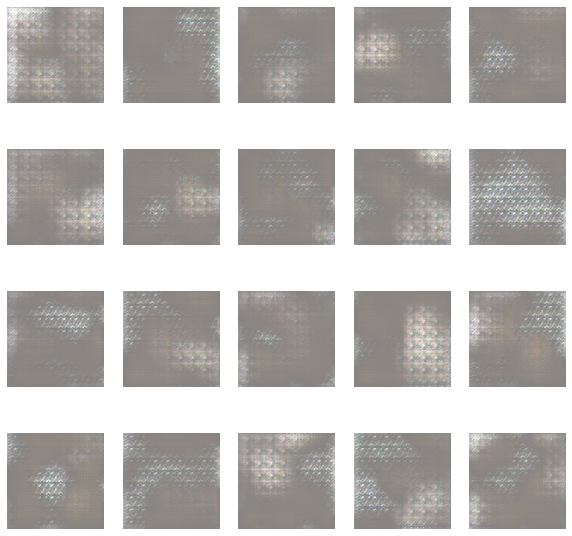

Epoch: 101/1000, Loss: [D_real = 0.822, D_fake = 0.531, G = 1.064], time: 19.13sec
Epoch: 102/1000, Loss: [D_real = 0.851, D_fake = 0.595, G = 0.881], time: 19.13sec
Epoch: 103/1000, Loss: [D_real = 0.718, D_fake = 0.518, G = 0.959], time: 19.14sec
Epoch: 104/1000, Loss: [D_real = 0.665, D_fake = 0.573, G = 0.886], time: 19.16sec
Epoch: 105/1000, Loss: [D_real = 0.634, D_fake = 0.693, G = 0.782], time: 19.15sec
Epoch: 106/1000, Loss: [D_real = 0.772, D_fake = 0.511, G = 1.042], time: 19.15sec
Epoch: 107/1000, Loss: [D_real = 0.618, D_fake = 0.688, G = 0.808], time: 19.19sec
Epoch: 108/1000, Loss: [D_real = 0.642, D_fake = 0.573, G = 0.998], time: 19.17sec
Epoch: 109/1000, Loss: [D_real = 0.730, D_fake = 0.612, G = 0.978], time: 19.16sec
Epoch: 110/1000, Loss: [D_real = 0.458, D_fake = 0.444, G = 1.155], time: 19.16sec
Epoch: 111/1000, Loss: [D_real = 0.417, D_fake = 0.691, G = 0.838], time: 19.15sec
Epoch: 112/1000, Loss: [D_real = 0.287, D_fake = 0.450, G = 1.390], time: 19.19sec
Epoc

Epoch: 200/1000, Loss: [D_real = 0.721, D_fake = 0.510, G = 1.026], time: 19.18sec
> Accuracy at epoch 200 [real: 40%, fake: 92%]


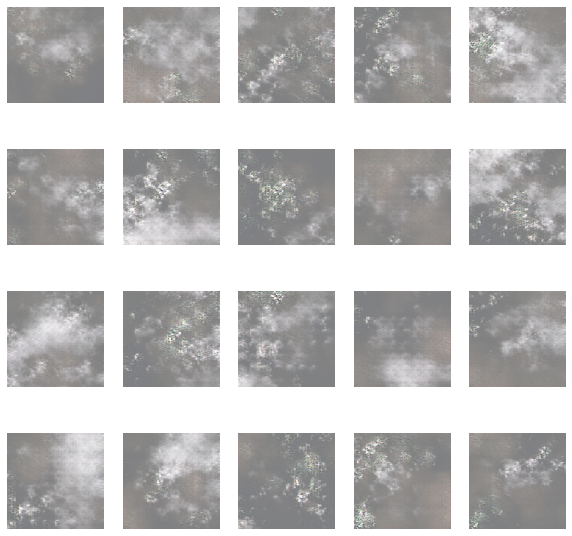

Epoch: 201/1000, Loss: [D_real = 0.579, D_fake = 0.612, G = 0.856], time: 19.14sec
Epoch: 202/1000, Loss: [D_real = 0.679, D_fake = 0.562, G = 0.976], time: 19.15sec
Epoch: 203/1000, Loss: [D_real = 0.621, D_fake = 0.661, G = 0.722], time: 19.17sec
Epoch: 204/1000, Loss: [D_real = 0.561, D_fake = 0.646, G = 0.893], time: 19.17sec
Epoch: 205/1000, Loss: [D_real = 0.692, D_fake = 0.690, G = 0.837], time: 19.16sec
Epoch: 206/1000, Loss: [D_real = 0.545, D_fake = 0.730, G = 0.876], time: 19.19sec
Epoch: 207/1000, Loss: [D_real = 0.546, D_fake = 0.661, G = 0.944], time: 19.17sec
Epoch: 208/1000, Loss: [D_real = 0.643, D_fake = 0.576, G = 0.915], time: 19.22sec
Epoch: 209/1000, Loss: [D_real = 0.625, D_fake = 0.540, G = 0.954], time: 19.21sec
Epoch: 210/1000, Loss: [D_real = 0.639, D_fake = 0.822, G = 0.775], time: 19.17sec
Epoch: 211/1000, Loss: [D_real = 0.719, D_fake = 0.479, G = 1.149], time: 19.18sec
Epoch: 212/1000, Loss: [D_real = 0.663, D_fake = 0.576, G = 1.166], time: 19.18sec
Epoc

Epoch: 300/1000, Loss: [D_real = 0.687, D_fake = 0.722, G = 0.985], time: 19.19sec
> Accuracy at epoch 300 [real: 37%, fake: 87%]


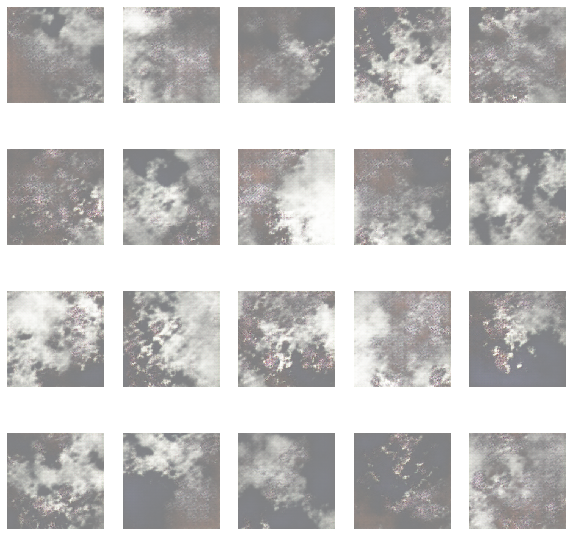

Epoch: 301/1000, Loss: [D_real = 0.770, D_fake = 0.590, G = 0.892], time: 19.16sec
Epoch: 302/1000, Loss: [D_real = 0.581, D_fake = 0.662, G = 0.879], time: 19.14sec
Epoch: 303/1000, Loss: [D_real = 0.623, D_fake = 0.649, G = 0.811], time: 19.2sec
Epoch: 304/1000, Loss: [D_real = 0.518, D_fake = 0.822, G = 0.875], time: 19.19sec
Epoch: 305/1000, Loss: [D_real = 0.717, D_fake = 0.570, G = 0.951], time: 19.17sec
Epoch: 306/1000, Loss: [D_real = 0.706, D_fake = 0.710, G = 0.767], time: 19.17sec
Epoch: 307/1000, Loss: [D_real = 0.608, D_fake = 0.610, G = 0.861], time: 19.17sec
Epoch: 308/1000, Loss: [D_real = 0.510, D_fake = 0.636, G = 0.823], time: 19.18sec
Epoch: 309/1000, Loss: [D_real = 0.588, D_fake = 0.585, G = 0.931], time: 19.18sec
Epoch: 310/1000, Loss: [D_real = 0.717, D_fake = 0.602, G = 0.920], time: 19.19sec
Epoch: 311/1000, Loss: [D_real = 0.638, D_fake = 0.600, G = 0.885], time: 19.16sec
Epoch: 312/1000, Loss: [D_real = 0.627, D_fake = 0.680, G = 0.833], time: 19.18sec
Epoch

Epoch: 400/1000, Loss: [D_real = 0.646, D_fake = 0.565, G = 1.032], time: 19.18sec
> Accuracy at epoch 400 [real: 55%, fake: 93%]


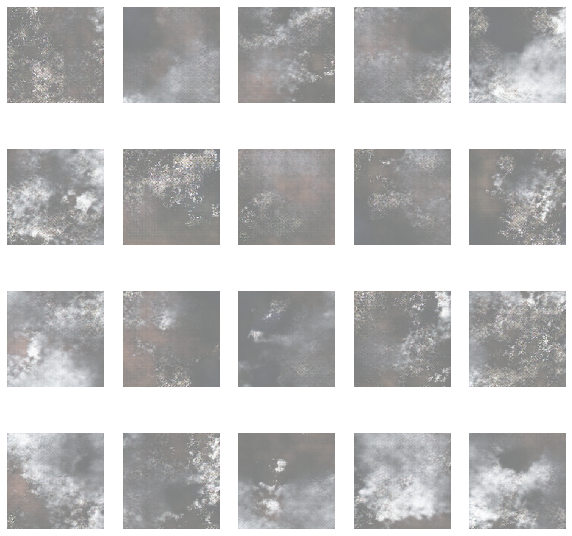

Epoch: 401/1000, Loss: [D_real = 0.627, D_fake = 0.537, G = 1.023], time: 19.14sec
Epoch: 402/1000, Loss: [D_real = 0.484, D_fake = 0.529, G = 0.913], time: 19.15sec
Epoch: 403/1000, Loss: [D_real = 0.624, D_fake = 0.582, G = 0.987], time: 19.16sec
Epoch: 404/1000, Loss: [D_real = 0.628, D_fake = 0.573, G = 0.921], time: 19.14sec
Epoch: 405/1000, Loss: [D_real = 0.504, D_fake = 0.614, G = 0.896], time: 19.17sec
Epoch: 406/1000, Loss: [D_real = 0.499, D_fake = 0.682, G = 0.939], time: 19.14sec
Epoch: 407/1000, Loss: [D_real = 0.550, D_fake = 0.671, G = 0.913], time: 19.17sec
Epoch: 408/1000, Loss: [D_real = 0.527, D_fake = 0.555, G = 0.931], time: 19.15sec
Epoch: 409/1000, Loss: [D_real = 0.593, D_fake = 0.630, G = 0.900], time: 19.16sec
Epoch: 410/1000, Loss: [D_real = 0.691, D_fake = 0.507, G = 1.058], time: 19.16sec
Epoch: 411/1000, Loss: [D_real = 0.598, D_fake = 0.666, G = 0.953], time: 19.16sec
Epoch: 412/1000, Loss: [D_real = 0.614, D_fake = 0.713, G = 0.791], time: 19.18sec
Epoc

Epoch: 500/1000, Loss: [D_real = 0.602, D_fake = 0.506, G = 1.102], time: 19.17sec
> Accuracy at epoch 500 [real: 71%, fake: 93%]


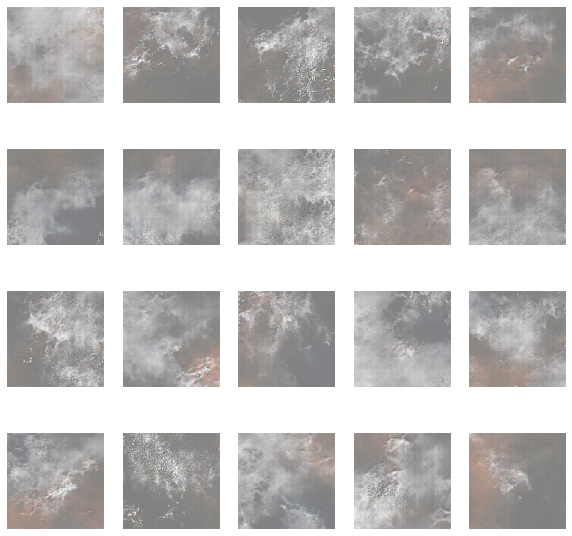

Epoch: 501/1000, Loss: [D_real = 0.541, D_fake = 0.474, G = 1.108], time: 19.14sec
Epoch: 502/1000, Loss: [D_real = 0.556, D_fake = 0.565, G = 1.196], time: 19.2sec
Epoch: 503/1000, Loss: [D_real = 0.435, D_fake = 0.457, G = 1.230], time: 19.14sec
Epoch: 504/1000, Loss: [D_real = 0.437, D_fake = 0.430, G = 1.335], time: 19.19sec
Epoch: 505/1000, Loss: [D_real = 0.575, D_fake = 0.495, G = 1.193], time: 19.17sec
Epoch: 506/1000, Loss: [D_real = 0.564, D_fake = 0.531, G = 1.075], time: 19.16sec
Epoch: 507/1000, Loss: [D_real = 0.450, D_fake = 0.540, G = 1.304], time: 19.18sec
Epoch: 508/1000, Loss: [D_real = 0.588, D_fake = 0.456, G = 1.185], time: 19.18sec
Epoch: 509/1000, Loss: [D_real = 0.549, D_fake = 0.408, G = 1.410], time: 19.17sec
Epoch: 510/1000, Loss: [D_real = 0.634, D_fake = 0.408, G = 1.308], time: 19.19sec
Epoch: 511/1000, Loss: [D_real = 0.420, D_fake = 0.432, G = 1.242], time: 19.17sec
Epoch: 512/1000, Loss: [D_real = 0.380, D_fake = 0.506, G = 1.343], time: 19.2sec
Epoch:

Epoch: 600/1000, Loss: [D_real = 0.213, D_fake = 0.354, G = 1.722], time: 19.33sec
> Accuracy at epoch 600 [real: 93%, fake: 96%]


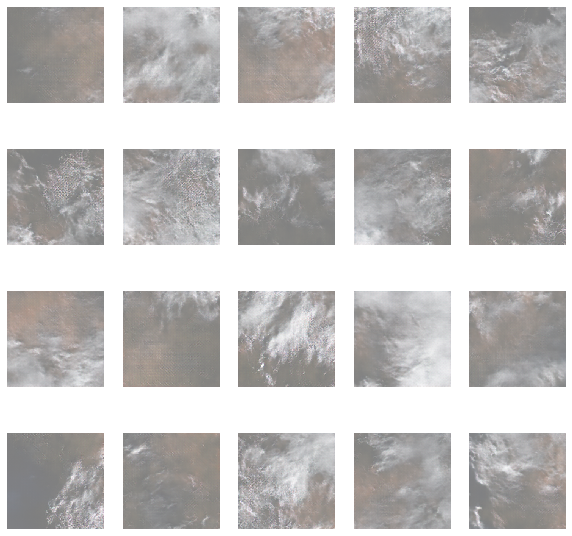

Epoch: 601/1000, Loss: [D_real = 0.505, D_fake = 0.359, G = 1.787], time: 19.24sec
Epoch: 602/1000, Loss: [D_real = 0.303, D_fake = 0.289, G = 1.510], time: 19.23sec
Epoch: 603/1000, Loss: [D_real = 0.221, D_fake = 0.348, G = 1.723], time: 19.25sec
Epoch: 604/1000, Loss: [D_real = 0.524, D_fake = 0.299, G = 1.484], time: 19.25sec
Epoch: 605/1000, Loss: [D_real = 0.388, D_fake = 0.267, G = 1.781], time: 19.28sec
Epoch: 606/1000, Loss: [D_real = 0.348, D_fake = 0.319, G = 1.940], time: 19.32sec
Epoch: 607/1000, Loss: [D_real = 0.374, D_fake = 0.283, G = 1.645], time: 19.28sec
Epoch: 608/1000, Loss: [D_real = 0.430, D_fake = 0.306, G = 1.814], time: 19.28sec
Epoch: 609/1000, Loss: [D_real = 0.367, D_fake = 0.400, G = 2.039], time: 19.27sec
Epoch: 610/1000, Loss: [D_real = 0.471, D_fake = 0.239, G = 1.633], time: 19.29sec
Epoch: 611/1000, Loss: [D_real = 0.223, D_fake = 0.283, G = 1.783], time: 19.28sec
Epoch: 612/1000, Loss: [D_real = 0.395, D_fake = 0.339, G = 1.616], time: 19.31sec
Epoc

Epoch: 700/1000, Loss: [D_real = 0.201, D_fake = 0.207, G = 2.501], time: 19.25sec
> Accuracy at epoch 700 [real: 94%, fake: 97%]


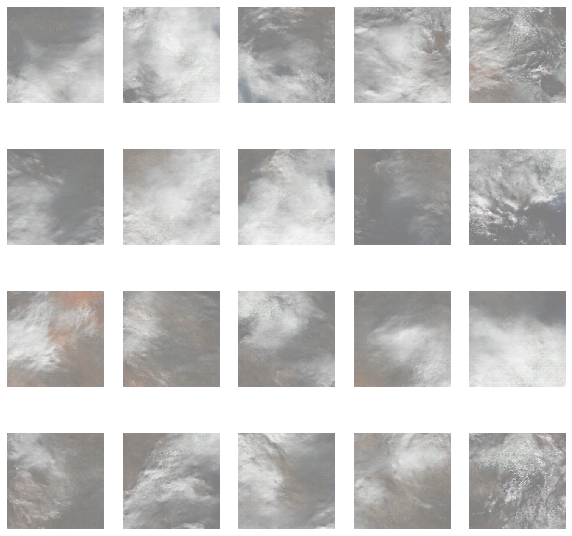

Epoch: 701/1000, Loss: [D_real = 0.134, D_fake = 0.221, G = 2.685], time: 19.23sec
Epoch: 702/1000, Loss: [D_real = 0.260, D_fake = 0.238, G = 2.459], time: 19.31sec
Epoch: 703/1000, Loss: [D_real = 0.157, D_fake = 0.174, G = 2.916], time: 19.24sec
Epoch: 704/1000, Loss: [D_real = 0.119, D_fake = 0.076, G = 3.011], time: 19.3sec
Epoch: 705/1000, Loss: [D_real = 0.183, D_fake = 0.163, G = 2.667], time: 19.26sec
Epoch: 706/1000, Loss: [D_real = 0.155, D_fake = 0.160, G = 2.495], time: 19.28sec
Epoch: 707/1000, Loss: [D_real = 0.151, D_fake = 0.166, G = 2.819], time: 19.31sec
Epoch: 708/1000, Loss: [D_real = 0.234, D_fake = 0.129, G = 2.861], time: 19.29sec
Epoch: 709/1000, Loss: [D_real = 0.374, D_fake = 0.187, G = 2.976], time: 19.31sec
Epoch: 710/1000, Loss: [D_real = 0.123, D_fake = 0.141, G = 2.846], time: 19.28sec
Epoch: 711/1000, Loss: [D_real = 0.080, D_fake = 0.171, G = 2.838], time: 19.26sec
Epoch: 712/1000, Loss: [D_real = 0.142, D_fake = 0.171, G = 2.582], time: 19.24sec
Epoch

Epoch: 800/1000, Loss: [D_real = 0.067, D_fake = 0.160, G = 3.484], time: 19.27sec
> Accuracy at epoch 800 [real: 97%, fake: 99%]


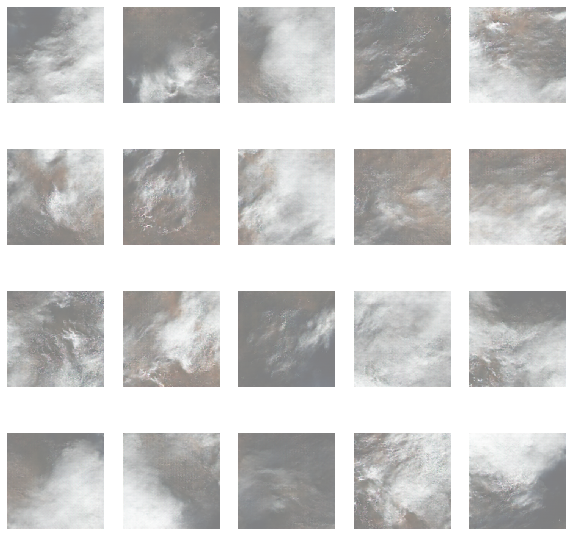

Epoch: 801/1000, Loss: [D_real = 0.031, D_fake = 0.149, G = 3.659], time: 19.25sec
Epoch: 802/1000, Loss: [D_real = 0.061, D_fake = 0.028, G = 4.264], time: 19.3sec
Epoch: 803/1000, Loss: [D_real = 0.185, D_fake = 0.116, G = 3.292], time: 19.29sec
Epoch: 804/1000, Loss: [D_real = 0.076, D_fake = 0.362, G = 3.471], time: 19.24sec
Epoch: 805/1000, Loss: [D_real = 0.124, D_fake = 0.113, G = 3.225], time: 19.27sec
Epoch: 806/1000, Loss: [D_real = 0.061, D_fake = 0.077, G = 3.447], time: 19.29sec
Epoch: 807/1000, Loss: [D_real = 0.127, D_fake = 0.067, G = 3.427], time: 19.27sec
Epoch: 808/1000, Loss: [D_real = 0.165, D_fake = 0.075, G = 3.394], time: 19.3sec
Epoch: 809/1000, Loss: [D_real = 0.099, D_fake = 0.212, G = 3.554], time: 19.28sec
Epoch: 810/1000, Loss: [D_real = 0.330, D_fake = 0.097, G = 2.976], time: 19.27sec
Epoch: 811/1000, Loss: [D_real = 0.041, D_fake = 0.057, G = 3.785], time: 19.28sec
Epoch: 812/1000, Loss: [D_real = 0.060, D_fake = 0.272, G = 4.015], time: 19.26sec
Epoch:

Epoch: 900/1000, Loss: [D_real = 0.066, D_fake = 0.037, G = 3.895], time: 19.29sec
> Accuracy at epoch 900 [real: 98%, fake: 94%]


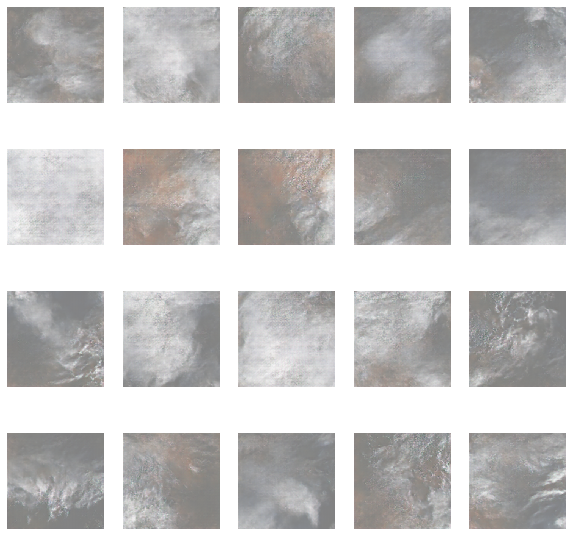

Epoch: 901/1000, Loss: [D_real = 0.040, D_fake = 0.023, G = 5.025], time: 19.33sec
Epoch: 902/1000, Loss: [D_real = 0.112, D_fake = 0.079, G = 3.369], time: 19.28sec
Epoch: 903/1000, Loss: [D_real = 0.041, D_fake = 0.051, G = 3.841], time: 19.35sec
Epoch: 904/1000, Loss: [D_real = 0.093, D_fake = 0.104, G = 3.969], time: 19.29sec
Epoch: 905/1000, Loss: [D_real = 0.152, D_fake = 0.028, G = 4.098], time: 19.33sec
Epoch: 906/1000, Loss: [D_real = 0.128, D_fake = 0.443, G = 4.325], time: 19.36sec
Epoch: 907/1000, Loss: [D_real = 0.038, D_fake = 0.102, G = 3.972], time: 19.34sec
Epoch: 908/1000, Loss: [D_real = 0.202, D_fake = 0.318, G = 4.270], time: 19.31sec
Epoch: 909/1000, Loss: [D_real = 0.260, D_fake = 0.035, G = 3.650], time: 19.35sec
Epoch: 910/1000, Loss: [D_real = 0.011, D_fake = 0.062, G = 4.834], time: 19.28sec
Epoch: 911/1000, Loss: [D_real = 0.068, D_fake = 0.255, G = 5.261], time: 19.32sec
Epoch: 912/1000, Loss: [D_real = 0.060, D_fake = 0.158, G = 4.167], time: 19.35sec
Epoc

Epoch: 1000/1000, Loss: [D_real = 0.023, D_fake = 0.018, G = 4.290], time: 19.26sec
> Accuracy at epoch 1000 [real: 98%, fake: 100%]


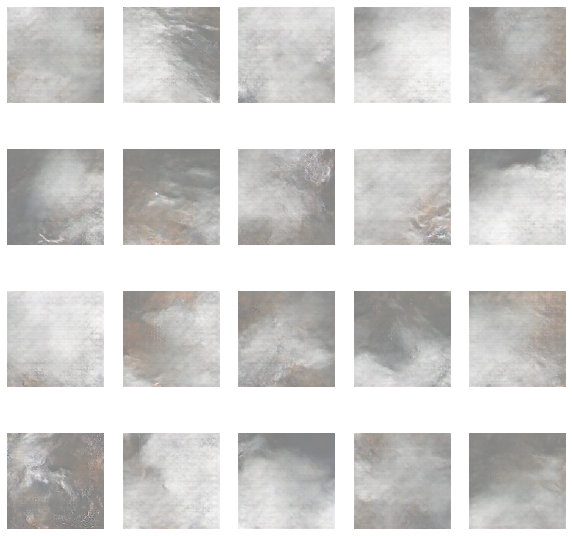

Total time for training 1000 epochs is 5h 20min 43.35sec sec


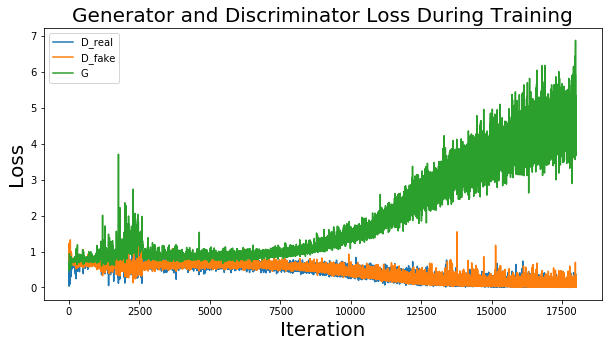

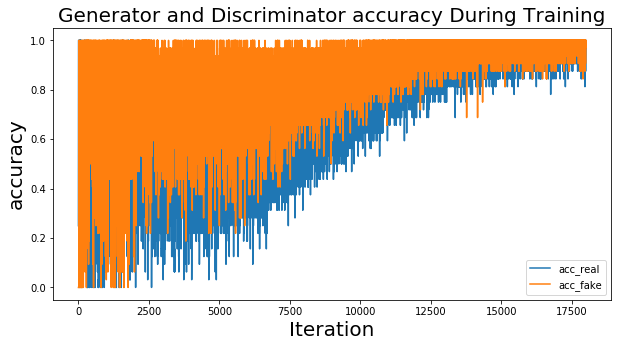

In [87]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=500, n_batch=128):
    
    start = time.time() 
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3, acc1, acc2 = [], [], [], [], []
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        start1 = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss); acc1.append(d_acc1); acc2.append(d_acc2)
        
        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}], time: {:s}'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss, _time(start1,time.time())))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
        
    print('Total time for training {} epochs is {} sec'.format(n_epochs, _time(start, time.time())))
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss) 

    # show accuracy curves
    acc = (acc1, acc2)
    plot_acc(acc)

discriminator = define_discriminator() 
generator = define_generator(latent_dim) 

# create the gan 
gan = define_gan(generator, discriminator)

# train model 
train(generator, discriminator, gan, img_data, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [89]:
# use the generator to generate n fake
def CloudFakeGenerator(g_model=generator, latent_dim =100, n_samples=1000, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

Cloud_fake = CloudFakeGenerator(generator, n_samples=1000)
